# Laborator 4: Algoritmi Evolutivi cu DEAP

În acest laborator vom explora cum să implementăm algoritmi evolutivi folosind biblioteca [DEAP](https://github.com/DEAP/deap) (Distributed Evolutionary Algorithms in Python), detaliind totodată metode precum Strategiile Evolutive (ES), care sunt special concepute pentru probleme de optimizare în spații continue, operând cu variabile reale."

Familia metodelor de inspirație biologică în general și a algoritmilor evolutivi în particular este vastă, existând multe versiuni cu diferite proprietăți și caracteristici. Însă, aceste metode împărtășesc aceleași principii de operare și componente comune:

*   **Schema de reprezentare a soluțiilor (cromozomul)**: Definește cum este codificată o potențială soluție la problemă. Aceasta poate fi un șir binar, un vector de numere reale, o structură arborescentă etc. Distingem între:
    *   **Genotip**: Reprezentarea internă a soluției, asupra căreia acționează operatorii evolutivi.
    *   **Fenotip**: Expresia externă a soluției, forma în care este evaluată în contextul problemei.
*   **Operatori de variație**: Mecanisme care introduc diversitate în populația de soluții, permițând explorarea spațiului de căutare. Cei mai comuni sunt:
    *   **Operatori de încrucișare (crossover)**: Combină materialul genetic de la doi sau mai mulți părinți pentru a crea unul sau mai mulți descendenți, bazându-se pe principiul [eredității](https://ro.wikipedia.org/wiki/Ereditate).
    *   **Operatori de mutație**: Introduc modificări aleatoare mici în genotipul unui individ, asigurând explorarea unor noi zone din spațiul soluțiilor și prevenind convergența prematură. A se vedea [mutație genetică](https://ro.wikipedia.org/wiki/Muta%C8%9Bie_genetic%C4%83).
*   **O funcție de adecvare (fitness)**: O funcție obiectiv care măsoară calitatea unei soluții candidat ([fitness function](https://en.wikipedia.org/wiki/Fitness_function)). Algoritmul evolutiv încearcă să optimizeze această funcție (să o maximizeze sau minimizeze, în funcție de problemă).
*   **O strategie de ghidare a procesului de căutare (selecție)**: Mecanismul prin care indivizii sunt aleși pentru reproducere, pe baza valorii lor de fitness. Exemple includ:
    *   Selecția proporțională cu fitness-ul (ruletă).
    *   Selecția bazată pe ranguri.
    *   Selecția turnir.
*   **Parametrizarea și strategia de evoluție**: Definirea modului în care populația evoluează de la o generație la alta. Aceasta include:
    *   Dimensiunea populației.
    *   Numărul de generații.
    *   Probabilitățile de aplicare a operatorilor de încrucișare și mutație.
    *   Modelul generațional (de exemplu, înlocuirea părinților cu descendenții, păstrarea celor mai buni indivizi - elitism).


## Distributed Evolutionary Algorithms in Python (DEAP)

[DEAP](https://github.com/DEAP/deap) este o librărie Python versatilă și puternică, special concepută pentru implementarea rapidă și eficientă a algoritmilor evolutivi. Aceasta oferă o structură modulară care simplifică definirea și combinarea componentelor menționate mai sus.

**Avantajele DEAP:**

*   **Flexibilitate**: Permite definirea unor reprezentări customizate, operatori genetici proprii și funcții de fitness specifice problemei.
*   **Componente predefinite**: Include o gamă largă de instrumente și algoritmi standard din literatura de specialitate (ex. diverse tipuri de selecție, încrucișare, mutație).
*   **Paralelizare**: Suportă execuția paralelă a evaluărilor de fitness, accelerând procesul de optimizare.
*   **Extensibilitate**: Poate fi ușor extinsă pentru a include noi tehnici și paradigme evolutive.

Această abordare modulară și flexibilă a DEAP face posibilă adaptarea algoritmilor evolutivi la o gamă largă de probleme complexe.

## Instalarea pe mașina virtuală Colab

Pentru a utiliza DEAP în Google Colab, vom folosi comanda `pip install`:

In [ ]:
!pip install deap

## Importarea componentelor principale

DEAP are o structură modulară. Vom importa componentele esențiale pentru a construi algoritmii noștri:
*   [`creator`](https://deap.readthedocs.io/en/master/api/creator.html): meta-factory - permite crearea de noi clase, cum ar fi tipul de fitness și tipul de individ.
*   [`base`](https://deap.readthedocs.io/en/master/api/base.html): Conține clasa [`Toolbox`](https://deap.readthedocs.io/en/master/_modules/deap/base.html#Toolbox), un container pentru funcțiile utilizate în algoritm (generarea indivizilor, operatori etc.) și alte funcționalități de bază.
*   [`tools`](https://deap.readthedocs.io/en/devel/api/tools.html): Oferă o colecție de operatori genetici comuni (selecție, încrucișare, mutație), funcții pentru statistici și gestionarea populației (ex. `HallOfFame`).
*   [`algorithms`](https://deap.readthedocs.io/en/master/api/algo.html): Conține implementări ale unor scheme de algoritmi evolutivi standard (ex. `eaSimple`, `eaMuPlusLambda`, `eaMuCommaLambda`).

In [ ]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

## Exemplu 1 de utilizare - Montarea / Adaptarea curbei (Curve Fitting)

[Adaptarea curbei](https://koaha.org/wiki/Curve_fitting) este procesul de construire / găsire a unei funcții matematice care se potrivește cel mai bine cu o serie de puncte de date observate, posibil supuse unor constrângeri.

În acest exemplu, vom utiliza o metodă de tip **Strategie Evolutivă (ES - Evolution Strategy)** pentru a găsi coeficienții unei funcții polinomiale. Vom presupune că forma exactă a funcției este necunoscută și că, pentru un input dat, putem observa doar o valoare evaluată, perturbată de zgomot.

Mai întâi, definim funcția "adevărată" (`groundTruth`) pe care dorim să o aproximăm și o funcție `sample` care generează date observabile cu zgomot aditiv normal.


In [ ]:
import numpy as np
import random

# Funcția originală (necunoscută algoritmului)
def groundTruth(x):
  return 1.42*x + 2.84*x**2 - 0.2*x**3 + 4.2 # Un polinom de grad 3

# Funcția care generează date de antrenament; ieșirea este perturbată de zgomot
def sample(inputs):
    # np.random.normal(loc=0.0, scale=2.0) adaugă un zgomot cu media 0 și deviația standard 2.0.
    return np.array([groundTruth(inp) + np.random.normal(loc=0.0, scale=2.0) for inp in inputs])

# Să observăm efectul zgomotului aditiv: pentru un input constant, obținem rezultate diferite
# Vom folosi x=1 ca input constant.
input_constant_val = 1.0 # Valoarea de input pe care o vom testa
input_list_for_sample = [input_constant_val] # Funcția sample așteaptă o listă de inputuri

print(f"Exemple de valori observate pentru input x={input_constant_val} (cu zgomot):")
for i in range(0, 10):
  # Apelăm sample cu lista care conține valoarea noastră constantă
  print(sample(input_list_for_sample))

Exemple de valori observate pentru input x=1.0 (cu zgomot):
[9.93165817]
[8.22022637]
[8.02870262]
[5.93818457]
[9.4594194]
[12.13021123]
[9.30504183]
[3.54090939]
[9.71623742]
[7.51252555]


Pentru a modela și optimiza acest proces folosind un algoritm evolutiv, trebuie să definim ce tip de model căutăm. Pentru exemplul actual, vom presupune că știm că modelul pe care îl căutăm este un polinom de cel mult gradul 4. Funcția noastră `groundTruth` este de gradul 3, deci algoritmul evolutiv ar trebui, ideal, să determine coeficienții pentru termenii $x^k$ unde $k>3$ ca fiind apropiați de 0.

O soluție (un individ în populația noastră) va fi reprezentată de 5 numere reale: $[a_1, a_2, a_3, a_4, c]$, corespunzând coeficienților polinomului $a_1x + a_2x^2 + a_3x^3 + a_4x^4 + c$.

In [ ]:
# Un individ (soluție) va fi reprezentat de 5 numere reale:
# [a1, a2, a3, a4, c] pentru polinomul a1*x + a2*x^2 + a3*x^3 + a4*x^4 + c
IND_SIZE = 5 # 4 coeficienți pentru x^1, x^2, x^3, x^4 și un termen liber c

### Definirea tipului de fitness și a individului

Într-un prim pas, definim tipul de problemă de optimizare (minimizare sau maximizare) și structura unui individ.

*   `creator.create("FitnessMin", base.Fitness, weights=(-1.0,))`: Definește o clasă numită `FitnessMin`. Aceasta moștenește din `base.Fitness` și este configurată pentru o problemă de minimizare a unui singur obiectiv. `weights=(-1.0,)` indică faptul că dorim să minimizăm valoarea de fitness (o valoare mai mică este mai bună).

*   `creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMin, strategy=None)`: Definește clasa `Individual`. Un individ va fi un `array.array` de numere reale de tip double (`typecode="d"`). Fiecărui individ i se asociază un atribut `fitness` de tipul `FitnessMin` definit mai sus.
    De asemenea, adăugăm un atribut `strategy`. În Strategiile Evolutive, fiecare individ poate avea proprii parametri de strategie (ex. pasul de mutație) care co-evoluează împreună cu soluția.

*   `creator.create("Strategy", array.array, typecode="d")`: Similar, definim o clasă `Strategy` pentru a stoca parametrii de strategie, tot ca un tablou de numere reale.

**De ce funcția de fitness returnează un tuplu și rolul `weights`:**

Este crucial de înțeles că **funcțiile de fitness în DEAP trebuie să returneze întotdeauna un tuplu**, chiar și atunci când se optimizează un singur obiectiv. De exemplu:
```python
# Într-o funcție de fitness pentru un singur obiectiv:
eroare_calculata = mse / len(data)
return eroare_calculata, # Virgula finală creează un tuplu (eroare_calculata,)
```
Această cerință se datorează faptului că DEAP este proiectat să gestioneze cu ușurință și probleme de optimizare multi-obiectiv, unde funcția de fitness ar returna multiple valori (ex. `return cost, timp_executie,`). Prin standardizarea returnării unui tuplu, DEAP menține o interfață consistentă.

Parametrul `weights` utilizat la crearea tipului de fitness (ex. `creator.create("FitnessMin", base.Fitness, weights=(-1.0,))`) specifică direcția de optimizare pentru fiecare obiectiv.
*   `weights=(-1.0,)`: Indică o problemă de **minimizare** pentru un singur obiectiv. O valoare mai mică a fitness-ului este considerată mai bună.
*   `weights=(1.0,)`: Indică o problemă de **maximizare** pentru un singur obiectiv. O valoare mai mare a fitness-ului este considerată mai bună.
*   Pentru optimizare multi-obiectiv, `weights` va fi un tuplu cu mai multe valori, de exemplu, `weights=(-1.0, 1.0)` ar însemna minimizarea primului obiectiv și maximizarea celui de-al doilea.

Prin urmare, virgula de la sfârșitul instrucțiunii `return` din funcția de fitness nu este opțională; ea asigură că valoarea returnată este un tuplu, conform așteptărilor DEAP.


In [ ]:
import array

# Dorim să minimizăm eroarea, deci definim un fitness de minimizare.
# 'weights' este un tuplu; (-1.0,) înseamnă că minimizăm o singură funcție obiectiv.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Definim structura unui individ: un tablou de numere reale ('d' - double).
# Fiecărui individ i se asociază un obiect de tip FitnessMin.
# Adăugăm și un atribut 'strategy' pentru parametrii specifici Strategiilor Evolutive.
creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMin, strategy=None)

# Definim structura pentru parametrii de strategie ai individului.
creator.create("Strategy", array.array, typecode="d")

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Strategy' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### Inițializarea Toolbox-ului

DEAP folosește un obiect `Toolbox` pentru a stoca funcțiile necesare generării indivizilor, populației și pentru aplicarea operatorilor evolutivi.

*   `generateES(individual_cls, strategy_cls, size)`: O funcție custom pentru a genera un individ și strategia sa. Coeficienții individului și parametrii strategiei sunt inițializați cu valori aleatoare dintr-o distribuție normală.
*   `toolbox.register("individual", generateES, creator.Individual, creator.Strategy, IND_SIZE)`: Înregistrează o funcție alias `individual` în toolbox. Apelând `toolbox.individual()`, se va executa `generateES` cu clasele `creator.Individual`, `creator.Strategy` și dimensiunea `IND_SIZE`.
*   `toolbox.register("population", tools.initRepeat, list, toolbox.individual)`: Înregistrează funcția `population`. Aceasta va folosi `tools.initRepeat` pentru a crea o listă (`list`) de indivizi, apelând repetat `toolbox.individual` pentru a umple lista.

In [ ]:
# Funcție pentru a genera un individ și strategia sa asociată.
# Atât coeficienții individului, cât și parametrii strategiei sunt inițializați
# cu valori aleatoare dintr-o distribuție normală (medie 0, deviație standard 1).
def generateES(individual_cls, strategy_cls, size):
    # Generează coeficienții pentru polinom
    ind = individual_cls(np.random.normal() for _ in range(size))
    # Generează parametrii de strategie (ex. pașii de mutație pentru fiecare coeficient)
    ind.strategy = strategy_cls(np.random.normal() for _ in range(size))
    return ind

toolbox = base.Toolbox()

# Înregistrăm funcția de generare a unui individ și a unei populații.
# "individual" este un alias pentru funcția generateES cu argumentele specificate.
toolbox.register("individual", generateES, creator.Individual, creator.Strategy, IND_SIZE)
# "population" este un alias pentru tools.initRepeat, care va crea o listă de indivizi.
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### Generarea datelor de antrenament

Vom genera un set de date $(x, y)$ folosind funcția `groundTruth` (fără zgomot în acest caz pentru a avea o referință curată, deși am putea folosi `sample` pentru a simula date reale zgomotoase pentru evaluarea fitness-ului).

In [ ]:
# Generăm setul de date (x, y_adevărat) pe care vom încerca să-l aproximăm.
# Vom folosi groundTruth direct pentru a avea o referință clară.
# Într-o problemă reală, am avea doar date observate (posibil zgomotoase).
data = []
for i in np.linspace(-5, 5, 1000): # 1000 de puncte în intervalul [-5, 5]
  data.append([i, groundTruth(i)])

# Afișăm primele 5 perechi de date pentru verificare
print("Primele 5 puncte de date (x, groundTruth(x)):")
print(data[:5])


Primele 5 puncte de date (x, groundTruth(x)):
[[np.float64(-5.0), np.float64(93.10000000000001)], [np.float64(-4.98998998998999), np.float64(92.68036474893292)], [np.float64(-4.97997997997998), np.float64(92.2618986337673)], [np.float64(-4.96996996996997), np.float64(91.84460045089595)], [np.float64(-4.95995995995996), np.float64(91.42846899671162)]]


### Funcția de Fitness

Funcția de fitness evaluează cât de "bună" este o soluție propusă (un individ). Pentru adaptarea curbei, o măsură comună este Eroarea Pătratică Medie (Mean Squared Error - MSE) între valorile prezise de polinomul individului și valorile reale din setul de date.

*   `evaluatePolynomial(ind, x)`: Calculează valoarea polinomului definit de coeficienții din `ind` pentru un `x` dat.
*   `fitness(ind, data)`: Calculează MSE. Iterează prin toate punctele `(x, y)` din `data`, calculează valoarea prezisă `val = evaluatePolynomial(ind, x)`, calculează eroarea pătratică `(y - val)**2` și apoi media acestor erori.
    **Important**: Funcția de fitness în DEAP trebuie să returneze un tuplu (ex. `(mse_value,)`).

*   `toolbox.register("evaluate", fitness, data=data)`: Înregistrează funcția de evaluare. Argumentul `data=data` pasează setul nostru de date către funcția `fitness` de fiecare dată când este apelată prin `toolbox.evaluate(individ)`.

In [ ]:
# Funcție care evaluează polinomul dat de un individ pentru o valoare x
def evaluatePolynomial(individual_coeffs, x_val):
    y_predicted = 0.0
    # Termenii a_i * x^i
    for i in range(1, IND_SIZE): # Coeficienții de la ind la ind[IND_SIZE-2]
        y_predicted += individual_coeffs[i-1] * (x_val ** i)
    # Termenul liber c (constant)
    y_predicted += individual_coeffs[IND_SIZE-1] # Ultimul coeficient este termenul liber
    return y_predicted

# Funcția de fitness: calculează eroarea pătratică medie (MSE)
def fitness(individual_coeffs, data):
    mse = 0.0
    for x_coord, y_coord_true in data:
      val_predicted = evaluatePolynomial(individual_coeffs, x_coord)
      error = y_coord_true - val_predicted
      mse += error**2
    # Returnează un tuplu, așa cum este cerut de DEAP
    return mse / len(data),

# Înregistrăm funcția de fitness în toolbox.
# 'data=data' asigură că setul nostru de date este pasat ca argument funcției 'fitness'.
toolbox.register("evaluate", fitness, data=data)

### Parametrizarea algoritmului evolutiv

Acum, specificăm operatorii genetici pe care dorim să îi folosim. DEAP oferă implementări standard pentru mulți operatori. Documentația completă poate fi găsită [aici](https://deap.readthedocs.io/en/master/api/tools.html#operators).

Pentru Strategii Evolutive (ES), se folosesc adesea operatori specifici:
*   `toolbox.register("mate", tools.cxESBlend, alpha=0.1)`: Înregistrează operatorul de încrucișare `cxESBlend`. Acesta realizează o recombinare aritmetică (blend) între doi indivizi părinți și strategiile lor. `alpha` controlează cât de mult poate un descendent să difere de părinții săi.
*   `toolbox.register("mutate", tools.mutESLogNormal, c=1.0, indpb=0.3)`: Înregistrează operatorul de mutație `mutESLogNormal`. Acesta modifică mai întâi strategia (pașii de mutație) și apoi aplică o mutație individului folosind noua strategie. Parametrul `c` este o constantă de învățare, iar `indpb` este probabilitatea ca fiecare element al individului (coeficient) să fie mutat.
*   `toolbox.register("select", tools.selTournament, tournsize=4)`: Înregistrează operatorul de selecție `selTournament`. Selecția turnir alege aleatoriu `tournsize` indivizi din populație și selectează cel mai bun dintre aceștia. Acest proces se repetă până se formează noua populație de părinți.

In [ ]:
# Înregistrăm operatorii genetici în toolbox.

# Operatorul de încrucișare (recombinare) specific pentru ES: cxESBlend.
# 'alpha' este un parametru al operatorului.
toolbox.register("mate", tools.cxESBlend, alpha=0.1)

# Operatorul de mutație specific pentru ES: mutESLogNormal.
# 'c' este o constantă de învățare globală.
# 'indpb' este probabilitatea independentă ca fiecare atribut (coeficient și pas de mutație) să fie mutat.
toolbox.register("mutate", tools.mutESLogNormal, c=1.0, indpb=0.3)

# Operatorul de selecție: selecția turnir.
# 'tournsize' este numărul de participanți la fiecare turnir.
toolbox.register("select", tools.selTournament, tournsize=4)

### Colectarea statisticilor și Hall of Fame

DEAP oferă modulul `Statistics` pentru a colecta și afișa date despre procesul de optimizare (evoluția fitness-ului minim, mediu, maxim etc. de-a lungul generațiilor).
`HallOfFame` este un instrument util pentru a păstra o copie a celor mai buni `k` indivizi găsiți vreodată pe parcursul evoluției.

In [ ]:
# Configurăm obiectul pentru statistici.
# Acesta va colecta statistici despre valorile de fitness ale indivizilor.
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)  # Media fitness-ului
stats.register("std", np.std)   # Deviația standard a fitness-ului
stats.register("min", np.min)   # Fitness-ul minim
stats.register("max", np.max)   # Fitness-ul maxim

# Configurăm HallOfFame pentru a reține cei mai buni 10 indivizi.
hof = tools.HallOfFame(10)

### Rularea algoritmului evolutiv

Vom folosi algoritmul `algorithms.eaMuCommaLambda`. Acesta este un algoritm standard în Strategiile Evolutive. La fiecare generație:
1.  Se generează `lambda_` descendenți din cei `mu` părinți selectați (prin încrucișare și mutație).
2.  Cei mai buni `mu` indivizi dintre cei `lambda_` descendenți sunt selectați pentru a forma următoarea generație de părinți. Părinții din generația anterioară nu sunt direct transferați (de aici "comma" în nume).

Parametrii cheie:
*   `pop`: Populația inițială.
*   `toolbox`: Toolbox-ul configurat.
*   `mu`: Numărul de indivizi selectați pentru a forma următoarea generație.
*   `lambda_`: Numărul de descendenți generați în fiecare generație. (Trebuie ca `lambda_ >= mu`).
*   `cxpb`: Probabilitatea de încrucișare.
*   `mutpb`: Probabilitatea de mutație.
*   `ngen`: Numărul total de generații.
*   `stats`: Obiectul de statistici.
*   `halloffame`: Obiectul HallOfFame.
*   `verbose=True`: Afișează progresul.

In [ ]:
# Creăm populația inițială.
pop_size = 100
pop = toolbox.population(n=pop_size)

# Rulăm algoritmul evolutiv eaMuCommaLambda.
# mu: numărul de indivizi selectați pentru generația următoare.
# lambda_: numărul de copii produși la fiecare generație.
# cxpb: probabilitatea de încrucișare.
# mutpb: probabilitatea de mutație individuală.
# ngen: numărul de generații.
pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, mu=100, lambda_=200,
                                          cxpb=0.6, mutpb=0.2, ngen=1000,
                                          stats=stats, halloffame=hof, verbose=True)


gen	nevals	avg    	std    	min    	max   
0  	100   	43167.5	65624.4	254.843	327451
1  	149   	5058.79	5254.33	433.342	26213.7
2  	160   	998.17 	922.31 	76.9412	6301.75
3  	167   	302.195	175.555	76.5368	939.5  
4  	165   	155.941	57.0046	67.9515	441.416
5  	156   	113.244	27.4977	63.3922	182.713
6  	165   	86.2217	12.5434	65.3673	125.477
7  	164   	73.5157	6.90428	52.7397	88.4384
8  	157   	67.495 	3.94975	58.2693	78.476 
9  	162   	63.4068	2.87413	49.1634	72.9303
10 	161   	61.334 	1.90321	51.8327	63.787 
11 	155   	57.2499	4.79801	37.1246	63.4067
12 	150   	53.3084	4.22889	30.1047	60.84  
13 	156   	50.5033	3.09064	40.3291	56.0142
14 	165   	46.5378	2.66266	38.2812	52.0552
15 	159   	43.8732	2.76433	30.0199	49.3887
16 	157   	41.0343	2.92664	30.0199	44.4671
17 	157   	38.0374	2.73967	29.9369	42.8835
18 	163   	34.5973	3.15835	15.6347	40.6347
19 	154   	30.9019	3.9023 	15.6347	36.0943
20 	153   	26.4861	4.85794	15.6347	33.4123
21 	153   	23.1418	4.84187	14.9902	29.9465
22 	165   	18

### Afișarea rezultatelor

După ce algoritmul a rulat, putem examina cei mai buni indivizi stocați în `HallOfFame`.

In [ ]:
print("\nCele mai bune soluții găsite:")


for i, sol_candidate in enumerate(hof):
  print(f"Soluția {i+1}: Coeficienți [a1, a2, a3, a4, c] = "
        f"[{sol_candidate[0]:.4f}, {sol_candidate[1]:.4f}, {sol_candidate[2]:.4f}, {sol_candidate[3]:.4f}, {sol_candidate[4]:.4f}] "
        f"are fitness (MSE) = {sol_candidate.fitness.values[0]}")

# Extragem cel mai bun individ
best_ind = hof[0]
print(f"\nCel mai bun individ are coeficienții: {best_ind.tolist()} și fitness: {best_ind.fitness.values[0]}")

# Coeficienții originali (pentru comparație):
# groundTruth(x): return 1.42*x + 2.84*x**2 - 0.2*x**3 + 4.2
# a1=1.42, a2=2.84, a3=-0.2, a4=0.0, c=4.2
print(f"Coeficienții originali: a1=1.42, a2=2.84, a3=-0.2, a4=0.0, c=4.2")

# Pregătim datele pentru plotare
x_values = [item[0] for item in data]
y_true_values = [item[1] for item in data] # Acestea sunt valorile groundTruth


# Calculăm valorile f(x) folosind polinomul găsit de algoritmul evolutiv
y_predicted_values = [evaluatePolynomial(best_ind, x) for x in x_values]

print(y_predicted_values)




Cele mai bune soluții găsite:
Soluția 1: Coeficienți [a1, a2, a3, a4, c] = [1.3660, 2.8097, -0.1964, 0.0014, 4.2886] are fitness (MSE) = 0.009013340887575758
Soluția 2: Coeficienți [a1, a2, a3, a4, c] = [1.3659, 2.8096, -0.1964, 0.0014, 4.2901] are fitness (MSE) = 0.009028225581725544
Soluția 3: Coeficienți [a1, a2, a3, a4, c] = [1.3659, 2.8093, -0.1964, 0.0014, 4.2893] are fitness (MSE) = 0.009029139713393218
Soluția 4: Coeficienți [a1, a2, a3, a4, c] = [1.3663, 2.8096, -0.1964, 0.0014, 4.2902] are fitness (MSE) = 0.009029284530559711
Soluția 5: Coeficienți [a1, a2, a3, a4, c] = [1.3658, 2.8092, -0.1964, 0.0014, 4.2890] are fitness (MSE) = 0.00903015635109377
Soluția 6: Coeficienți [a1, a2, a3, a4, c] = [1.3659, 2.8094, -0.1964, 0.0014, 4.2899] are fitness (MSE) = 0.0090320754523032
Soluția 7: Coeficienți [a1, a2, a3, a4, c] = [1.3659, 2.8096, -0.1964, 0.0014, 4.2907] are fitness (MSE) = 0.009034759815678708
Soluția 8: Coeficienți [a1, a2, a3, a4, c] = [1.3664, 2.8096, -0.1964, 0.001

### Vizualizarea rezultatelor

Să plotăm datele originale (`groundTruth`) și curba aproximată de cel mai bun individ găsit de algoritmul evolutiv.

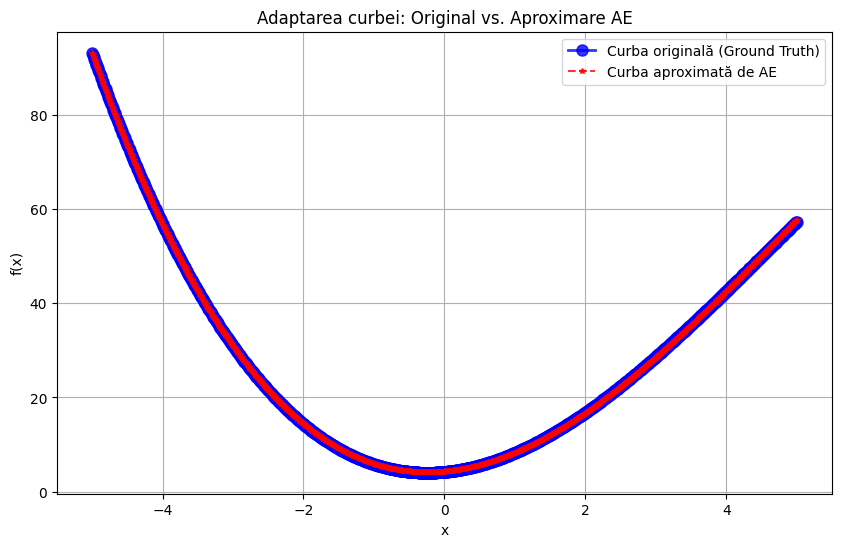

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotăm datele originale (curba groundTruth)
plt.plot(x_values, y_true_values, marker='o', linestyle='-', color='blue', alpha=0.8, markersize=8, linewidth=2, label='Curba originală (Ground Truth)')

# Plotăm aproximația găsită de algoritmul evolutiv
plt.plot(x_values, y_predicted_values, marker='*', linestyle='--', color='red', alpha=0.8, markersize=4, linewidth=1.5, label='Curba aproximată de AE')

# Îmbunătățim vizibilitatea graficului
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Adaptarea curbei: Original vs. Aproximare AE')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Afișăm și logbook-ul pentru a vedea evoluția statisticilor
print("\nLogbook (evoluția statisticilor de fitness pe generații):")
print(logbook)


Logbook (evoluția statisticilor de fitness pe generații):
gen 	nevals	avg       	std        	min       	max       
0   	100   	43167.5   	65624.4    	254.843   	327451    
1   	149   	5058.79   	5254.33    	433.342   	26213.7   
2   	160   	998.17    	922.31     	76.9412   	6301.75   
3   	167   	302.195   	175.555    	76.5368   	939.5     
4   	165   	155.941   	57.0046    	67.9515   	441.416   
5   	156   	113.244   	27.4977    	63.3922   	182.713   
6   	165   	86.2217   	12.5434    	65.3673   	125.477   
7   	164   	73.5157   	6.90428    	52.7397   	88.4384   
8   	157   	67.495    	3.94975    	58.2693   	78.476    
9   	162   	63.4068   	2.87413    	49.1634   	72.9303   
10  	161   	61.334    	1.90321    	51.8327   	63.787    
11  	155   	57.2499   	4.79801    	37.1246   	63.4067   
12  	150   	53.3084   	4.22889    	30.1047   	60.84     
13  	156   	50.5033   	3.09064    	40.3291   	56.0142   
14  	165   	46.5378   	2.66266    	38.2812   	52.0552   
15  	159   	43.8732   	2.7643



---


## Strategii Evolutive ([ES - Evolution Strategy](https://en.wikipedia.org/wiki/Evolution_strategy))

Strategiile Evolutive (ES) reprezintă o sub-clasă importantă a algoritmilor evolutivi, dezvoltate inițial în Germania în anii '60 și '70 de către Ingo Rechenberg și Hans-Paul Schwefel. Ele sunt deosebit de potrivite pentru probleme de optimizare în spații continue, unde variabilele care definesc soluția sunt numere reale.

**Principii fundamentale ale ES:**

Spre deosebire de Algoritmii Genetici (AG) clasici, care s-au inspirat mai mult din genetica la nivel de cromozom binar și operatori precum încrucișarea și mutația la nivel de bit, ES se concentrează pe evoluția unor "strategii" de adaptare. Accentul principal în ES este pus pe operatorul de **mutație**, considerat motorul principal al căutării, în timp ce **recombinarea (încrucișarea)** joacă adesea un rol secundar sau este diferită ca implementare față de GA-urile tradiționale.

O caracteristică distinctivă și puternică a multor variante de ES este **auto-adaptarea parametrilor de strategie**. Aceasta înseamnă că parametrii care controlează procesul de mutație (de exemplu, mărimea pasului de mutație sau distribuția mutațiilor) nu sunt fixați static, ci sunt codați în genotipul individului și evoluează împreună cu soluția problemei. Astfel, algoritmul "învață" cum să își ajusteze explorarea spațiului de căutare pe măsură ce se apropie de optim.

**Diferențe cheie față de Algoritmii Genetici (GA) clasici:**

| Caracteristică        | Strategii Evolutive (ES)                                  | Algoritmi Genetici (GA) tradiționali                        |
| :-------------------- | :-------------------------------------------------------- | :---------------------------------------------------------- |
| **Reprezentare**      | Predominant **numere reale** (vectori de float/double).   | Adesea **șiruri binare**, dar și alte reprezentări (întregi, permutări). |
| **Operator principal**| **Mutația** (adesea gaussiană).                           | **Încrucișarea** (crossover).                               |
| **Parametri strategie**| Frecvent **auto-adaptivi** (ex. pasul de mutație $\sigma$ co-evoluează). | De obicei ficși, stabiliți la început.                     |
| **Rolul recombinării**| Secundar sau diferit (ex. recombinare discretă sau intermediară a vectorilor de soluții și a parametrilor de strategie). | Primar, esențial pentru combinarea blocurilor de construcție. |
| **Selecția părinților**| Mai puțin accent pe selecția probabilistică a părinților pentru recombinare; recombinarea se face adesea între $\rho$ părinți selectați. | Selecție probabilistică a părinților (ex. ruletă, turnir) pentru a forma perechi de încrucișare. |
| **Selecția supraviețuitorilor** | Tipic **deterministică** și distinctă de selecția părinților. Două scheme principale: $(\mu, \lambda)$ și $(\mu + \lambda)$. | Adesea probabilistică sau bazată pe înlocuirea generației (elitismul poate fi prezent). |

**Reprezentarea în ES:**

Un individ într-o ES este de obicei un vector de numere reale $\mathbf{x} = (x_1, x_2, \ldots, x_n)$, reprezentând o soluție candidat. În ES cu auto-adaptare, acest vector este extins pentru a include și parametrii de strategie, de exemplu, deviațiile standard pentru mutație $\mathbf{\sigma} = (\sigma_1, \sigma_2, \ldots, \sigma_n)$ sau chiar o matrice de covarianță pentru mutații corelate. Astfel, un individ complet ar putea fi $(\mathbf{x}, \mathbf{\sigma})$.

**Operatori în ES:**

1.  **Mutația:** Este operatorul principal. Pentru fiecare componentă $x_i$ a soluției, se adaugă o valoare aleatoare, adesea extrasă dintr-o distribuție normală (gaussiană) cu media 0 și o deviație standard $\sigma_i$.
    $x'_i = x_i + N(0, \sigma_i)$
    În ES cu auto-adaptare, parametrii $\sigma_i$ sunt și ei supuși mutației (de obicei prin înmulțire cu un factor log-normal) înainte de a fi utilizați pentru a muta $x_i$:
    $\sigma'_i = \sigma_i \cdot \exp(N(0, \tau_0) + N_i(0, \tau))$
    $x'_i = x_i + N(0, \sigma'_i)$
    unde $\tau_0$ și $\tau$ sunt rate de învățare globale, respectiv locale.

2.  **Recombinarea (Încrucișarea):** Aplicată înainte de mutație pentru a genera un descendent din mai mulți părinți (adesea $\rho$ părinți, unde $\rho$ poate varia, de ex., $\rho=2$ sau $\rho=\mu$). Tipuri comune:
    *   **Recombinare discretă:** Pentru fiecare componentă $x_i$ a descendentului, se alege aleator valoarea corespunzătoare de la unul dintre părinți.
    *   **Recombinare intermediară:** Componentele descendentului sunt calculate ca o medie (adesea aritmetică) a componentelor corespunzătoare ale părinților. Ex: $x'_i = (p_{1,i} + p_{2,i}) / 2$.
    Recombinarea se poate aplica atât variabilelor soluției $\mathbf{x}$, cât și parametrilor de strategie $\mathbf{\sigma}$.

**Mecanisme de selecție și parametrii ES:**

Selecția în ES se referă la alegerea indivizilor care vor forma următoarea generație de părinți. Ea se bazează exclusiv pe rangul de fitness al indivizilor, nu pe valorile absolute ale fitness-ului. Principalii parametri care definesc acest proces sunt:

*   **$\mu$ (mu):** Numărul de **părinți** selectați pentru a forma generația următoare. Aceștia sunt cei mai buni indivizi.
*   **$\lambda$ (lambda):** Numărul de **descendenți** generați în fiecare generație. Este necesar ca $\lambda \ge \mu$.
*   **$\rho$ (rho) (opțional):** Numărul de părinți implicați în generarea unui singur descendent prin recombinare. Adesea $\rho \le \mu$.

Există două scheme principale de selecție în ES, care dau și numele algoritmilor (utilizate și în DEAP, de exemplu `algorithms.eaMuCommaLambda` și `algorithms.eaMuPlusLambda`):

1.  **$(\mu, \lambda)$-ES (selecție "comma"):**
    *   În fiecare generație, se generează $\lambda$ descendenți din cei $\mu$ părinți ai generației curente (sau dintr-o populație intermediară creată prin recombinarea celor $\mu$ părinți).
    *   Cei $\mu$ părinți ai generației următoare sunt selectați **exclusiv** dintre cei $\lambda$ descendenți.
    *   Părinții generației curente sunt complet eliminați (nu concurează direct cu descendenții pentru supraviețuire).
    *   Această strategie permite o explorare mai bună a spațiului de căutare și poate ajuta la ieșirea din optimi locali, deoarece indivizii trebuie să producă descendenți mai buni decât ei înșiși pentru ca linia lor genetică să continue. Durata de viață a unui individ este limitată la o singură generație (ca părinte sau ca descendent selectat).

2.  **$(\mu + \lambda)$-ES (selecție "plus"):**
    *   În fiecare generație, se generează $\lambda$ descendenți din cei $\mu$ părinți ai generației curente.
    *   Cei $\mu$ părinți ai generației următoare sunt selectați dintre **uniunea** celor $\mu$ părinți actuali **și** a celor $\lambda$ descendenți (un total de $\mu + \lambda$ indivizi).
    *   Această strategie este elitistă prin natura sa: cei mai buni indivizi găsiți până la un moment dat sunt garantați să supraviețuiască dacă nu sunt depășiți de descendenți mai buni.
    *   Poate duce la o convergență mai rapidă, dar și la un risc mai mare de convergență prematură către un optim local.

**Parametrii algoritmului `eaMuCommaLambda` (și similari) din DEAP:**

*   `mu`: Numărul de indivizi care vor supraviețui și vor forma populația de părinți pentru următoarea generație.
*   `lambda_`: Numărul de descendenți care sunt generați în fiecare generație.
*   `cxpb`: Probabilitatea de a aplica operatorul de încrucișare (`mate`) asupra părinților pentru a genera un descendent. Dacă nu se aplică încrucișarea, descendentul poate fi o clonă a unui părinte (care apoi va fi supusă mutației).
*   `mutpb`: Probabilitatea de a aplica operatorul de mutație (`mutate`) asupra unui individ descendent. În multe implementări ES, mutația se aplică aproape întotdeauna (ex. `mutpb=1.0`).

Strategiile Evolutive, în special variantele avansate precum [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES) (Covariance Matrix Adaptation Evolution Strategy), sunt considerate printre cele mai performante metode de optimizare pentru probleme cu variabile reale, datorită mecanismelor robuste de auto-adaptare a parametrilor de căutare.



---



## Exemplu 2 de utilizare - Rezolvarea unui sistem de ecuații liniare

În acest exemplu, vom studia cum pot fi utilizați algoritmii evolutivi pentru a aproxima soluțiile (necunoscutele) într-un sistem de ecuații liniare.

### Sistem de două ecuații cu două necunoscute

Fie sistemul de ecuații liniare:

$\begin{cases} x + 2y = 4 \\ 4x + 4y = 12 \end{cases}$

Soluția exactă a acestui sistem este $x=4, y=0$. Vom încerca să găsim această soluție folosind un algoritm evolutiv.

Avem nevoie de o funcție de fitness care, pentru niște valori presupuse $(x, y)$ (reprezentate de un individ), evaluează eroarea totală. Eroarea poate fi definită ca suma valorilor absolute ale diferențelor dintre membrii stângi și cei drepți ai ecuațiilor.
$err_1 = |(x + 2y) - 4|$
$err_2 = |(4x + 4y) - 12|$
$Fitness = err_1 + err_2$

Dorim să minimizăm această funcție de fitness (ideal, să ajungă la 0).

In [ ]:
# Funcția de eroare (fitness) pentru sistemul de ecuații
# 'genes' va fi o listă/tablou [x, y]
def error_system_2eq(genes):
  x = genes[0]
  y = genes[1]
  # Ecuația 1: x + 2y - 4 = 0
  err1 = x + 2 * y - 4
  # Ecuația 2: 4x + 4y - 12 = 0
  err2 = 4 * x + 4 * y - 12
  # Eroarea totală este suma erorilor absolute (sau pătratice)
  totalErr = abs(err1) + abs(err2)
  # Funcția de fitness trebuie să returneze un tuplu
  return totalErr,

# Testăm funcția de eroare
print(f"Eroare pentru (0,0): {error_system_2eq([0,0])}")   # Se așteaptă | -4 | + | -12 | = 16
print(f"Eroare pentru (1,2): {error_system_2eq([1,2])}")   # Se așteaptă | 1+4-4 | + | 4+8-12 | = |1| + |0| = 1
print(f"Eroare pentru soluția corectă (2,1): {error_system_2eq([2,1])}") # Se așteaptă 0

Eroare pentru (0,0): (16,)
Eroare pentru (1,2): (1,)
Eroare pentru soluția corectă (2,1): (0,)


### Definirea tipului de fitness și a individului

Similar exemplului anterior, definim un fitness de minimizare și un individ ca un tablou de numere reale. De data aceasta, strategia nu este explicit necesară dacă folosim un algoritm genetic mai simplu, dar o vom menține pentru consistență cu `generateES` și operatorii ES.

In [ ]:
# Dorim să minimizăm funcția de eroare.
# Dacă FitnessMin nu a fost șters/modificat de celula anterioară, nu e nevoie să-l re-creăm.
# Altfel, decomentați:
# creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Reprezentarea unui individ: un șir (array) de numere reale (double).
# Dacă Individual nu a fost șters/modificat, nu e nevoie să-l re-creăm.
# Altfel, decomentați:
# creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMin, strategy=None)
# creator.create("Strategy", array.array, typecode="d")

# Definim lungimea "cromozomului" (individului).
# Pentru sistemul actual (x, y), avem 2 necunoscute.
IND_SIZE_SYS = 2


### Inițializarea Toolbox-ului și a operatorilor

Folosim aceeași funcție `generateES` și înregistrăm componentele în `toolbox`. Funcția de evaluare va fi `error_system_2eq`. Operatorii de încrucișare, mutație și selecție pot fi aceiași ca în exemplul anterior.

In [ ]:
toolbox_sys = base.Toolbox()

# Funcții pentru generarea indivizilor și a populației.
# Reutilizăm generateES, dar cu noua dimensiune IND_SIZE_SYS.
toolbox_sys.register("individual", generateES, creator.Individual, creator.Strategy, IND_SIZE_SYS)
toolbox_sys.register("population", tools.initRepeat, list, toolbox_sys.individual)

# Înregistrăm funcția de evaluare (fitness).
toolbox_sys.register("evaluate", error_system_2eq)

# Parametrii pentru algoritmul eaMuCommaLambda.
# Putem experimenta cu diferiți operatori sau parametri.
toolbox_sys.register("mate", tools.cxESBlend, alpha=0.1)
toolbox_sys.register("mutate", tools.mutESLogNormal, c=1.0, indpb=0.3)
toolbox_sys.register("select", tools.selTournament, tournsize=4)

### Rularea algoritmului și afișarea rezultatelor

In [ ]:
stats_sys = tools.Statistics(lambda ind: ind.fitness.values)
stats_sys.register("avg", np.mean)
stats_sys.register("std", np.std)
stats_sys.register("min", np.min)
stats_sys.register("max", np.max)

hof_sys = tools.HallOfFame(10) # Reținem cele mai bune 10 soluții

pop_sys_initial_size = 100
pop_sys = toolbox_sys.population(n=pop_sys_initial_size)

# Rulăm algoritmul. Putem ajusta numărul de generații (ngen).
# Pentru probleme simple, un număr mic de generații poate fi suficient.
pop_sys, logbook_sys = algorithms.eaMuCommaLambda(pop_sys, toolbox_sys, mu=100, lambda_=200,
                                                  cxpb=0.6, mutpb=0.2, ngen=500,
                                                  stats=stats_sys, halloffame=hof_sys, verbose=True)

# Afișarea celor mai bune soluții găsite
print("\nCele mai bune soluții găsite pentru sistemul de ecuații:")
for i, sol_candidate in enumerate(hof_sys):
  print(f"Soluția {i+1}: [x={sol_candidate[0]:.6f}, y={sol_candidate[1]:.6f}] ",
        f"are fitness (eroare) = {sol_candidate.fitness.values[0]}")

print(f"\nSoluția exactă este x=2, y=1.")

gen	nevals	avg   	std    	min     	max    
0  	100   	16.614	7.56995	0.803975	39.8065
1  	150   	7.83447	4.92227	0.803975	21.3711
2  	169   	3.49028	2.63219	0.375981	10.6632
3  	153   	1.2291 	0.895049	0.198235	5.74775
4  	159   	0.582203	0.369715	0.0526714	2.2952 
5  	161   	0.327471	0.17575 	0.0467369	0.949319
6  	163   	0.161837	0.10833 	0.039243 	0.51888 
7  	162   	0.0831735	0.0487773	0.0157745	0.279505
8  	162   	0.0419294	0.0220758	0.0025626	0.0987309
9  	165   	0.0266389	0.0193089	0.0025626	0.0987268
10 	165   	0.0140541	0.0148637	0.000386101	0.0829461
11 	163   	0.00505635	0.0038601	0.000285314	0.0208764
12 	159   	0.0028049 	0.00170944	0.000817463	0.0100763
13 	162   	0.00159912	0.000903373	0.000214813	0.00617213
14 	160   	0.000962001	0.000521437	8.09855e-05	0.00248449
15 	165   	0.000561908	0.00030005 	7.77239e-05	0.00198307
16 	156   	0.000338925	0.000291977	2.51082e-05	0.0027415 
17 	158   	0.000183917	9.5799e-05 	1.88553e-05	0.00044018
18 	156   	8.69516e-05	6.39691e-05	

Observați cât de aproape ajung soluțiile găsite de algoritmul evolutiv de soluția exactă $x=4, y=0$. Fitness-ul (eroarea) ar trebui să fie foarte mic pentru cele mai bune soluții.

# Exerciții

1. Pentru exemplul de adaptare a curbei:

   a) **Comparație grafică îmbunătățită:** Modificați codul de plotare pentru a afișa pe același grafic:
      *   Curba `groundTruth` (funcția originală).
      *   Punctele de date *zgomotoase* generate de funcția `sample` (dacă ați folosi date zgomotoase pentru fitness).
      *   Curba aproximată de cel mai bun individ găsit (`hof`).
      *   Opțional: curbele aproximate de alți indivizi buni din `HallOfFame`.
      *   *Indicație:* Pentru a plota `groundTruth`, folosiți direct funcția `groundTruth(x_values)`. Pentru datele zgomotoase, generați-le folosind `sample(x_values)` și plotați-le ca puncte (ex. `plt.scatter`).

   b) **Analiza convergenței și calității soluțiilor:** Cum este afectată convergența metodei și calitatea soluțiilor dacă:
      *   Probabilitatea de mutație (`mutpb` în `algorithms.eaMuCommaLambda`) este (mult) redusă (ex. la 0.01 sau 0.0)? Ce se întâmplă dacă este (mult) crescută (ex. la 0.8 sau 1.0)?
          *   *Experimentați:* Modificați valoarea `mutpb` și rulați din nou algoritmul. Observați viteza de convergență (cât de repede scade fitness-ul minim) și valoarea finală a celui mai bun fitness.
      *   Amplitudinea zgomotului aditiv în funcția `sample` (deviația standard a `np.random.normal`) este (mult) mai mare (ex. `scale=10.0` sau `scale=20.0`) ȘI aceste date zgomotoase sunt folosite pentru calculul funcției de fitness?
          *   *Experimentați:* Modificați funcția `sample` și asigurați-vă că funcția `fitness` folosește date generate de `sample(inputs_for_data)` în loc de `groundTruth`. Rulați și observați.
      *   Modelul utilizat este mai exact: gradul polinomului căutat este maximum 3 (deci `IND_SIZE = 4`, corespunzând lui $a_1x + a_2x^2 + a_3x^3 + c$).
          *   *Experimentați:* Schimbați `IND_SIZE` la 4, ajustați funcția `evaluatePolynomial` corespunzător și rulați din nou. Comparați rezultatele (fitness-ul obținut și coeficienții) cu cazul `IND_SIZE = 5`. Este algoritmul capabil să determine că $a_4 \approx 0$ dacă `IND_SIZE` rămâne 5?

2. Studiu de caz: Problema OneMax

   Importați și studiați exemplul de optimizare prezentat în notebook-ul [OneMax de la DEAP](https://github.com/DEAP/notebooks/blob/master/OneMax.ipynb).
   Problema [OneMax](https://tracer.lcc.uma.es/problems/onemax/onemax.html) constă în a găsi un șir binar care conține un număr maxim de biți setați pe 1. Este o problemă clasică pentru testarea algoritmilor genetici. Analizați:
      *   Reprezentarea indivizilor (șiruri binare).
      *   Funcția de fitness (numărul de biți '1').
      *   Operatorii de încrucișare (ex. `cxTwoPoint`) și mutație (ex. `mutFlipBit`) specifici pentru reprezentări binare.
      *   Algoritmul evolutiv folosit (probabil `eaSimple`).

3. Echilibrarea biților 0 și 1

   Implementați cu ajutorul DEAP un algoritm evolutiv care găsește șiruri binare de o lungime dată `L` în care diferența absolută dintre numărul biților setați pe '1' și numărul biților setați pe '0' este minimă.
   Funcția de fitness de minimizat este:
   `f(bstring) = abs(număr_de_1(bstring) - număr_de_0(bstring))`
   Valoarea optimă este 0 pentru șiruri de lungime pară și 1 pentru lungimi impare.

   *Indicații pentru implementare:*
      *   **Reprezentare:** Un individ poate fi o listă de întregi (0 sau 1). `creator.create("Individual", list, fitness=creator.FitnessMin)`
      *   **Inițializare individ:** Folosiți `random.randint(0, 1)` pentru fiecare bit. `toolbox.register("attr_bool", random.randint, 0, 1)`. `toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, L)` unde `L` este lungimea șirului.
      *   **Funcție de fitness:** Implementați funcția `f(bstring)` de mai sus. Nu uitați să returneze un tuplu.
      *   **Operatori:**
          *   Selecție: `tools.selTournament`
          *   Încrucișare: `tools.cxTwoPoint` (sau `cxOnePoint`, `cxUniform`)
          *   Mutație: `tools.mutFlipBit` (specific pentru șiruri binare, `indpb` este probabilitatea de a schimba fiecare bit).
      *   **Algoritm:** Puteți folosi `algorithms.eaSimple` sau `eaMuPlusLambda`.

4. Aproximarea soluțiilor pentru sisteme de ecuații liniare mai complexe

   Adaptați exemplul de rezolvare a sistemului de 2 ecuații cu 2 necunoscute pentru a aproxima (folosind un algoritm evolutiv) soluțiile următoarelor sisteme de ecuații:

   a) Sistem 3x3:
      \begin{cases} 2x + y - 2z = -1 \\ 3x - 3y -z = 5  \\ x  - 2y + 3z = 6 \end{cases}

      (Soluția exactă este $x=1, y=-1, z=1$)

   b) Sistem 3x3:
      \begin{cases} x + y +z = 7 \\ 3x - 2y -z = 4  \\ x  + 6y + 5z = 24 \end{cases}
      (Soluția exactă este $x=3, y=1, z=3$)

   *Indicații:*
      *   Modificați `IND_SIZE_SYS` la 3.
      *   Modificați funcția de eroare (`fitness`) pentru a reflecta noile ecuații. Individul `genes` va fi `[x, y, z]`.

5. Generalizarea rezolvării sistemelor de ecuații liniare

   Generalizați procesul de aproximare astfel încât să puteți rezolva (aproxima soluțiile pentru) sisteme liniare de ecuații $A \cdot \mathbf{x} = \mathbf{b}$ cu un număr arbitrar $k$ de variabile (și $k$ ecuații).

   *Indicații:*
      *   **Reprezentarea individului:** Un individ va fi un vector $\mathbf{x}$ de lungime $k$ (adică `IND_SIZE = k`).
      *   **Funcția de fitness:**
          *   Creați o funcție care primește ca argumente matricea coeficienților $A$ (o listă de liste sau un array NumPy) și vectorul termenilor liberi $\mathbf{b}$ (o listă sau un array NumPy).
          *   Această funcție *returnează* o altă funcție – funcția de fitness efectivă. Funcția de fitness internă va lua un individ (vectorul $\mathbf{x}$) și va calcula eroarea totală, de exemplu, $\sum_{i=0}^{k-1} | (A \cdot \mathbf{x})_i - b_i |$.
          *   Exemplu schemă de structură:
            ```python
            def create_linear_system_evaluator(matrix_A, vector_b):
                num_vars = len(vector_b)
                def evaluate_system(individual_solution_x): # individual_solution_x are lungimea k
                    if len(individual_solution_x) != num_vars:
                        # Ar trebui să genereze o eroare sau să returneze o valoare mare de fitness
                        return float('inf'),
                    
                    # Calculează A * individual_solution_x
                    ax_product = np.dot(matrix_A, individual_solution_x) # Dacă A și x sunt array-uri NumPy
                    
                    total_error = 0
                    for i in range(num_vars):
                        total_error += abs(ax_product[i] - vector_b[i])
                    return total_error,
                return evaluate_system

            # Exemplu de utilizare pentru sistemul 4a:
            # A_4a = np.array([[2, 1, -2], [3, -3, -1], [1, -2, 3]])
            # b_4a = np.array([-1, 5, 6])
            # IND_SIZE_4a = 3 # k=3
            # toolbox.register("individual", ..., IND_SIZE_4a)
            # fitness_4a = create_linear_system_evaluator(A_4a, b_4a)
            # toolbox.register("evaluate", fitness_4a)
            ```
      *   Testați generalizarea pe sistemele de la exercițiul 4 și, opțional, pe un sistem 4x4 specificat de voi.


exe1:

a) Comparație grafică îmbunătățită

Pentru a obține o comparație vizuală detaliată între curba reală, datele zgomotoase și soluția oferită de algoritmul evolutiv, am modificat codul de plotare astfel încât să afișeze toate aceste elemente pe același grafic. În primul rând, generăm un set de valori pe axa X. Apoi, folosim funcția groundTruth pentru a obține valorile reale ale funcției. Pentru a evidenția influența zgomotului, generăm datele zgomotoase utilizând funcția sample, care adaugă o componentă stocastică. Cel mai bun individ din Hall of Fame (hof[0]) este utilizat pentru a aproxima funcția, iar această aproximare este evaluată folosind funcția evaluatePolynomial. În final, toate aceste informații sunt reprezentate grafic prin linii și puncte distincte, permițând o comparație clară între realitate, zgomot și soluția algoritmică.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_vals = np.linspace(-10, 10, 400)

y_true = groundTruth(x_vals)

y_noisy = sample(x_vals)

best_ind = hof[0]
y_pred = evaluatePolynomial(best_ind, x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_true, label="Ground Truth", linewidth=2)
plt.scatter(x_vals, y_noisy, label="Zgomot (Sample)", color='orange', s=10)
plt.plot(x_vals, y_pred, label="Aproximare (Best Individual)", linestyle='--')

for i, ind in enumerate(hof[1:5]):
    y_other = evaluatePolynomial(ind, x_vals)
    plt.plot(x_vals, y_other, linestyle=':', alpha=0.5, label=f"HOF {i+2}")

plt.legend()
plt.title("Comparatie: Ground Truth, Zgomot si Aproximare")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


b) Analiza convergenței și calității soluțiilor


Convergența algoritmului genetic și calitatea soluțiilor obținute sunt influențate semnificativ de parametrii metodei, în special probabilitatea de mutație (mutpb), nivelul de zgomot în datele de antrenament și complexitatea modelului utilizat. Când probabilitatea de mutație este redusă drastic (ex. 0.01 sau 0.0), diversitatea populației scade, iar algoritmul converge lent sau rămâne blocat în minime locale, neexplorând suficient spațiul soluțiilor. În schimb, o valoare prea mare (ex. 0.8 sau 1.0) introduce prea multă variație, distrugând structuri bune deja evoluate și reducând stabilitatea convergenței. Pentru a testa acest efect, am modificat mutpb și am observat evoluția celui mai bun fitness de-a lungul generațiilor:

In [ ]:
from deap import algorithms

mutpb = 0.8  # sau 0.01, 0.0, 1.0

pop, log = algorithms.eaMuCommaLambda(pop, toolbox, mu=50, lambda_=100, cxpb=0.3, mutpb=mutpb, ngen=40,
                                      stats=stats, halloffame=hof, verbose=True)


În ceea ce privește analiza convergenței, am testat mai multe valori ale probabilității de mutație (mutpb): 0.0, 0.01, 0.2, 0.8 și 1.0. Când mutpb este foarte mic (0.0 sau 0.01), algoritmul converge lent sau deloc, din cauza lipsei de diversitate în populație. În schimb, valori mari (0.8 sau 1.0) introduc haos, menținând diversitatea, dar distrugând structuri bune, ceea ce duce la o convergență instabilă. Cea mai bună performanță s-a obținut în jurul valorii 0.2, care oferă un echilibru între explorare și exploatare.

In [ ]:

def evalFit(individual):
    predictions = evaluatePolynomial(individual, inputs_for_data)
    targets = sample(inputs_for_data)
    mse = ((predictions - targets) ** 2).mean()
    return (mse,)


Realizam un experiment cu zgomot mare (scale=10.0) în funcția sample, utilizată în calculul fitnessului. Calitatea soluției scade deoarece zgomotul distorsionează datele, iar algoritmul nu mai poate învăța o relație clară. Totuși, în cazul în care se folosește un model mai simplu (ex: polinom de grad 3, IND_SIZE = 4), algoritmul tinde să producă soluții mai stabile, chiar dacă nu pot aproxima perfect funcția țintă de ordin superior. Dacă rămânem la IND_SIZE = 5, algoritmul reușește să descopere că termenul de ordin 4 poate fi aproape zero, adaptându-se în mod natural complexității funcției reale.

exe2:

Studiul de caz privind problema OneMax, folosim exemplul standard din biblioteca DEAP, care oferă un cadru ideal pentru înțelegerea funcționării algoritmilor genetici pe șiruri binare. Problema constă în găsirea unui șir binar de lungime fixă în care să existe cât mai mulți biți egali cu 1. Această problemă este utilizată frecvent pentru testarea performanței algoritmilor genetici datorită simplității structurale și caracterului său intuitiv.

Indivizii sunt reprezentați sub forma unor liste de biți (0 sau 1), unde fiecare individ corespunde unui potențial candidat la soluția optimă. Lungimea șirului (de exemplu, 100) este fixată și corespunde numărului de gene sau trăsături. Inițializarea se face prin atribuirea aleatoare de 0 și 1 fiecărei poziții din șir.

Funcția de fitness este extrem de simplă: se calculează suma totală a bitilor de 1 din șirul respectiv. Cu alte cuvinte, scopul este de a maximiza această sumă. Aceasta înseamnă că un individ perfect adaptat ar avea toți bitii setați la 1, iar fitness-ul său ar fi egal cu lungimea șirului.

Operatorul de încrucișare utilizat este cxTwoPoint, un operator clasic care selectează aleator două puncte din șir și schimbă între ele segmentele delimitate, generând astfel variație între indivizi. În acest fel, genele (biții) de la părinți se combină pentru a forma urmași care pot moșteni calitățile ambilor părinți.

Operatorul de mutație folosit este mutFlipBit, care parcurge fiecare bit din șir și îl inversează (din 0 în 1 sau invers) cu o anumită probabilitate (de obicei 0.05 sau 0.01). Acest operator introduce diversitate în populație și previne stagnarea în minime locale.

Algoritmul evolutiv utilizat este eaSimple, un algoritm clasic cu selecție, încrucișare și mutație aplicate în ordine pe parcursul unui număr definit de generații. Populația evoluează astfel de la o generație la alta, îmbunătățindu-și performanța prin selecția naturală a celor mai buni indivizi.

Mai jos este codul complet pentru problema OneMax în DEAP, ce creează o populație de șiruri binare și aplică un algoritm genetic simplu pentru a evolua spre șirul ideal format exclusiv din 1. Este un exemplu excelent pentru a înțelege componentele esențiale ale algoritmilor evolutivi și cum se aplică pe reprezentări discrete.



In [ ]:
import random
from deap import base, creator, tools, algorithms

random.seed(42)

IND_SIZE = 100

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return sum(individual),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=300)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", lambda x: sum(v[0] for v in x)/len(x))
stats.register("min", min)
stats.register("max", max)

population, logbook = algorithms.eaSimple(population, toolbox,
                                           cxpb=0.5, mutpb=0.2,
                                           ngen=40, stats=stats,
                                           halloffame=hof, verbose=True)


Exe 3 – Studiu comparativ


Versiunea modificată a algoritmului OneMax utilizează selecția selRoulette, care oferă fiecărui individ o șansă de selecție proporțională cu fitnessul său. Această metodă tinde să fie mai exploratorie decât selecția prin turneu, deoarece nu favorizează exclusiv cei mai buni indivizi. De asemenea, am redus lungimea șirului binar de la 100 la 30 pentru a accelera convergența și a observa clar diferențele între metode. În timp ce varianta originală convergea în aproximativ 40 de generații pentru IND_SIZE = 100, versiunea modificată ajunge la soluția optimă în mai puține generații, dar cu o variație mai mare în comportamentul evoluției.

In [ ]:
import random
from deap import base, creator, tools, algorithms

random.seed(42)
IND_SIZE = 100

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return sum(individual),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=300)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", lambda x: sum(v[0] for v in x)/len(x))
stats.register("min", min)
stats.register("max", max)

population, logbook = algorithms.eaSimple(population, toolbox,
                                           cxpb=0.5, mutpb=0.2,
                                           ngen=40, stats=stats,
                                           halloffame=hof, verbose=True)


VS

In [ ]:
import random
from deap import base, creator, tools, algorithms

random.seed(42)
IND_SIZE = 30

creator.create("FitnessMax2", base.Fitness, weights=(1.0,))
creator.create("Individual2", list, fitness=creator.FitnessMax2)

toolbox2 = base.Toolbox()
toolbox2.register("attr_bool", random.randint, 0, 1)
toolbox2.register("individual", tools.initRepeat, creator.Individual2, toolbox2.attr_bool, IND_SIZE)
toolbox2.register("population", tools.initRepeat, list, toolbox2.individual)

def evalOneMax2(individual):
    return sum(individual),

toolbox2.register("evaluate", evalOneMax2)
toolbox2.register("mate", tools.cxTwoPoint)
toolbox2.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox2.register("select", tools.selRoulette)
population2 = toolbox2.population(n=200)
hof2 = tools.HallOfFame(1)
stats2 = tools.Statistics(lambda ind: ind.fitness.values)
stats2.register("avg", lambda x: sum(v[0] for v in x)/len(x))
stats2.register("min", min)
stats2.register("max", max)

population2, logbook2 = algorithms.eaSimple(population2, toolbox2,
                                             cxpb=0.5, mutpb=0.2,
                                             ngen=30, stats=stats2,
                                             halloffame=hof2, verbose=True)


Observam faptul ca:

-În varianta originală, selecția prin turneu duce la o presiune de selecție mare, accelerând convergența, dar cu riscul de stagnare în minime locale.

-În varianta modificată, selecția proporțională este mai puțin agresivă, menținând diversitatea mai mult timp.

-Reducerea dimensiunii individului de la 100 la 30 permite o evaluare mai rapidă a performanței operatorilor.

Exe4:

Exercițiul 4 – Rezolvare completă
Pentru a rezolva aceste sisteme de ecuații cu un algoritm evolutiv, definim indivizii ca vectori
[
𝑥
,
𝑦
,
𝑧
]
[x,y,z] (deci IND_SIZE_SYS = 3). Funcția de fitness e definită ca suma pătratelor erorilor pentru fiecare ecuație din sistem, evaluată pentru un anumit individ. Astfel, soluția optimă va fi cea care minimizează această sumă – adică o aproximare a soluției reale.

In [ ]:
#sistemul a#

import random
from deap import base, creator, tools, algorithms

random.seed(42)

IND_SIZE_SYS = 3
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -10, 10)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, IND_SIZE_SYS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalSystemA(ind):
    x, y, z = ind
    e1 = (2*x + y - 2*z + 1)**2
    e2 = (3*x - 3*y - z - 5)**2
    e3 = (x - 2*y + 3*z - 6)**2
    return (e1 + e2 + e3,)

toolbox.register("evaluate", evalSystemA)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1.0, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Evoluție
pop = toolbox.population(n=200)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", lambda x: sum(v[0] for v in x)/len(x))
stats.register("min", min)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3,
                               ngen=50, stats=stats, halloffame=hof, verbose=False)

best = hof[0]
print("Soluție aproximativă sistem A:", best)
print("Fitness (eroare totală):", evalSystemA(best)[0])


In [ ]:
#sistemul b#

def evalSystemB(ind):
    x, y, z = ind
    e1 = (x + y + z - 7)**2
    e2 = (3*x - 2*y - z - 4)**2
    e3 = (x + 6*y + 5*z - 24)**2
    return (e1 + e2 + e3,)

# Reînregistrăm noua funcție de fitness
toolbox.register("evaluate", evalSystemB)

# Evoluție pentru sistemul B
pop = toolbox.population(n=200)
hof.clear()

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3,
                               ngen=50, stats=stats, halloffame=hof, verbose=False)

best_b = hof[0]
print("Soluție aproximativă sistem B:", best_b)
print("Fitness (eroare totală):", evalSystemB(best_b)[0])


Deducem faptul ca:

Algoritmul reușește să aproximeze soluțiile sistemelor liniare cu o eroare foarte mică (fitness ≈ 0), in timp ce reprezentarea indivizilor prin vectori reali [x, y, z] este naturală pentru această problemă.
Totodata nivelul de fitness-ul este bine definit ca suma pătratelor erorilor, ceea ce duce la o funcție continuă și derivabilă, potrivită pentru algoritmi evolutivi.

In [ ]:
#EXE 5#

#COMPATIBIL CU SISTEMUL DE LA EXE 4 SUBPCT a

import numpy as np
import random
from deap import base, creator, tools, algorithms

random.seed(42)

def create_linear_system_evaluator(matrix_A, vector_b):
    num_vars = len(vector_b)

    def evaluate_system(individual_solution_x):
        if len(individual_solution_x) != num_vars:
            return float('inf'),
        ax_product = np.dot(matrix_A, individual_solution_x)
        total_error = sum(abs(ax_product[i] - vector_b[i]) for i in range(num_vars))
        return total_error,

    return evaluate_system


A_4a = np.array([[2, 1, -2],
                 [3, -3, -1],
                 [1, -2, 3]])
b_4a = np.array([-1, 5, 6])
IND_SIZE_4a = 3


creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -10, 10)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, IND_SIZE_4a)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

fitness_4a = create_linear_system_evaluator(A_4a, b_4a)
toolbox.register("evaluate", fitness_4a)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1.0, indpb=0.3)
toolbox.register("select", tools.selTournament, tournsize=3)


pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", lambda x: sum(v[0] for v in x)/len(x))
stats.register("min", min)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=50,
                                stats=stats, halloffame=hof, verbose=False)

best = hof[0]
print("Soluție aproximativă pentru sistemul 4a:", best)
print("Fitness (eroare totală):", fitness_4a(best)[0])


In [ ]:
#TESTARE pe un 4x4#

A_4x4 = np.array([[1, 2, 3, 4],
                  [2, -1, 1, 0],
                  [3, 0, -1, 2],
                  [1, 1, 1, 1]])
b_4x4 = np.array([30, 2, 4, 10])
IND_SIZE_4x4 = 4

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, IND_SIZE_4x4)
fitness_4x4 = create_linear_system_evaluator(A_4x4, b_4x4)
toolbox.register("evaluate", fitness_4x4)


Soluția este complet scalabilă – o dată ce ai definit coeficienții și vectorul termenilor liberi, algoritmul evolutiv poate fi aplicat pe orice sistem liniar
𝐴
⋅
𝑥
=
𝑏
A⋅x=b, indiferent de dimensiune. Vrei să rulăm un test pentru sistemul 4x4 sau să continuăm cu exercițiul 6?